# Captcha Recognition

## Information
- dataset : https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
- reference source
    - https://www.kaggle.com/xinlux/cnn-rnn-ctc
    - https://keras.io/examples/vision/captcha_ocr
- blog : https://yscho03.tistory.com/82    

## Setup

In [1]:
import os
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.3.0


In [3]:
seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

## Load The data

In [4]:
BASE_DIR = os.getcwd()
DATASET_DIR = os.path.join(BASE_DIR, 'datasets', 'captcha_images_v2')

In [5]:
if not os.path.isdir(DATASET_DIR):
    path_to_downloaded_file = tf.keras.utils.get_file(
        "captcha_images_v2.zip",
        "https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip",    
        cache_dir=os.getcwd(),
        archive_format=['zip'],
        extract=True)
    zip_filepath = os.path.join(BASE_DIR, 'datasets', 'captcha_images_v2.zip')
    os.remove(zip_filepath)
# Downloading data from https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
# 9076736/9075967 [==============================] - 1s 0us/step    

9076736/9075967 [==============================] - 1s 0us/step


## Visualize the data

Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)


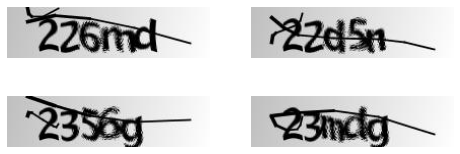

In [6]:
data_dir = Path(DATASET_DIR)

images = list(data_dir.glob("*.png"))
sample_images = images[:4]

_,ax = plt.subplots(2,2, figsize=(8,3))
for i in range(4):
    img = cv2.imread(str(sample_images[i]))
    print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')

## Preprocessing

In [7]:
characters = set()
captcha_length = []
dataset = []

for img_path in images:
    label = img_path.name.split(".png")[0]
    captcha_length.append(len(label))
    dataset.append((str(img_path), label))
    for ch in label:
        characters.add(ch)

characters = sorted(characters)
dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)
dataset = dataset.sample(frac=1.).reset_index(drop=True)
dataset.head()

,img_path,label
0,D:\projects\research\captcha_recognition\datas...,6xxdx
1,D:\projects\research\captcha_recognition\datas...,e4gd7
2,D:\projects\research\captcha_recognition\datas...,dn26n
3,D:\projects\research\captcha_recognition\datas...,42dw4
4,D:\projects\research\captcha_recognition\datas...,3nnpw


In [9]:
'>>> charsets: {}'.format(characters)

">>> charsets: ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']"

In [11]:
training_data, validation_data = train_test_split(dataset, test_size=0.1, random_state=seed)

training_data = training_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)

char_to_labels = {char:idx for idx, char in enumerate(characters)}
labels_to_char = {val:key for key, val in char_to_labels.items()}

print('>>> char_to_labels: {}'.format(char_to_labels))
print('>>> labels_to_char: {}'.format(labels_to_char))

>>> char_to_labels: {'2': 0, '3': 1, '4': 2, '5': 3, '6': 4, '7': 5, '8': 6, 'b': 7, 'c': 8, 'd': 9, 'e': 10, 'f': 11, 'g': 12, 'm': 13, 'n': 14, 'p': 15, 'w': 16, 'x': 17, 'y': 18}
>>> labels_to_char: {0: '2', 1: '3', 2: '4', 3: '5', 4: '6', 5: '7', 6: '8', 7: 'b', 8: 'c', 9: 'd', 10: 'e', 11: 'f', 12: 'g', 13: 'm', 14: 'n', 15: 'p', 16: 'w', 17: 'x', 18: 'y'}


In [12]:
def is_valid_captcha(captcha):
    for ch in captcha:
        if not ch in characters:
            return False
    return True

def generate_arrays(df, resize=True, img_height=50, img_width=200):    
    num_items = len(df)
    images = np.zeros((num_items, img_height, img_width), dtype=np.float32)
    labels = [0]*num_items
    
    for i in range(num_items):
        img = cv2.imread(df["img_path"][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        if resize: 
            img = cv2.resize(img, (img_width, img_height))
        
        img = (img/255.).astype(np.float32)
        label = df["label"][i]
        
        if is_valid_captcha(label):
            images[i, :, :] = img
            labels[i] = label
    
    return images, np.array(labels)

In [13]:
training_data, training_labels = generate_arrays(df=training_data)
validation_data, validation_labels = generate_arrays(df=validation_data)

((50, 200), 'b5fm7', (200, 50, 1))

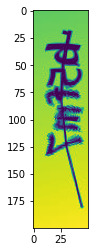

In [14]:
plt.imshow(training_data[0].T)
training_data[0].shape, training_labels[0], np.expand_dims(training_data[0].T, axis=-1).shape

## Create Dataset objects

In [16]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self,
                 data,
                 labels,
                 char_map,
                 batch_size=16,
                 img_width=200,
                 img_height=50,
                 downsample_factor=4,
                 max_length=5,
                 shuffle=True
                ):
        self.data = data
        self.labels = labels
        self.char_map = char_map
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))    
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        # 1. Get the next batch indices
        curr_batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        
        # 2. This isn't necessary but it can help us save some memory
        # as not all batches the last batch may not have elements
        # equal to the batch_size 
        batch_len = len(curr_batch_idx)
        
        # 3. Instantiate batch arrays
        batch_images = np.ones((batch_len, self.img_width, self.img_height, 1),
                               dtype=np.float32)
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * \
                                (self.img_width // self.downsample_factor - 2)
        label_length = np.zeros((batch_len, 1), dtype=np.int64)
        
        
        for j, idx in enumerate(curr_batch_idx):
            # 1. Get the image and transpose it
            img = self.data[idx].T
            # 2. Add extra dimenison
            img = np.expand_dims(img, axis=-1)
            # 3. Get the correpsonding label
            text = self.labels[idx]
            # 4. Include the pair only if the captcha is valid
            if is_valid_captcha(text):
                label = [self.char_map[ch] for ch in text]
                batch_images[j] = img
                batch_labels[j] = label
                label_length[j] = len(text)
        
        batch_inputs = {
                'input_data': batch_images,
                'input_label': batch_labels,
                'input_length': input_length,
                'label_length': label_length,
                }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)
        
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [17]:
# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width=200
img_height=50 

# Factor  by which the image is going to be downsampled
# by the convolutional blocks
downsample_factor=4

# Maximum length of any captcha in the data
max_length=5

# Get a generator object for the training data
train_data_generator = DataGenerator(data=training_data,
                                     labels=training_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=True
                                    )

# Get a generator object for the validation data 
valid_data_generator = DataGenerator(data=validation_data,
                                     labels=validation_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )

## Build Model

In [18]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        # On test time, just return the computed loss
        return loss

In [19]:
def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(img_width, img_height, 1),
                            name='input_data',
                            dtype='float32')
    labels = layers.Input(name='input_label', shape=[max_length], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')
    
    # First conv block
    x = layers.Conv2D(32,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv1')(input_img)
    x = layers.MaxPooling2D((2,2), name='pool1')(x)
    
    # Second conv block
    x = layers.Conv2D(64,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv2')(x)
    x = layers.MaxPooling2D((2,2), name='pool2')(x)
    
    # We have used two max pool with pool size and strides of 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing it to RNNs
    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)
    
    # RNNs
    x = layers.Bidirectional(layers.LSTM(128,
                                         return_sequences=True,
                                         dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(64,
                                         return_sequences=True,
                                         dropout=0.25))(x)
    
    # Predictions
    x = layers.Dense(len(characters)+1,
              activation='softmax', 
              name='dense2',
              kernel_initializer='he_normal')(x)
    
    # Calculate CTC
    output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)
    
    # Define the model
    model = keras.models.Model(inputs=[input_img,
                                       labels,
                                       input_length,
                                       label_length],
                                outputs=output,
                                name='ocr_model_v1')
    
    # Optimizer
    sgd = keras.optimizers.SGD(learning_rate=0.002,
                               decay=1e-6,
                               momentum=0.9,
                               nesterov=True,
                               clipnorm=5)
    
    # Compile the model and return 
    model.compile(optimizer=sgd,metrics=['accuracy'])
    return model

In [20]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         input_data[0][0]                 
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

## Training

In [21]:
checkpoint_save_path = os.path.join(BASE_DIR, 'checkpoint', 'BaseCNN.ckpt')
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

In [22]:
# Add early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   restore_best_weights=True)

# Train the model
history = model.fit(train_data_generator,
                    validation_data=valid_data_generator,
                    epochs=50,
                    callbacks=[es])

Epoch 1/50
59/59 [==============================] - 13s 220ms/step - loss: 24.1759 - accuracy: 0.0000e+00 - val_loss: 16.4636 - val_accuracy: 0.0000e+00
Epoch 2/50
59/59 [==============================] - 10s 171ms/step - loss: 16.4264 - accuracy: 0.0000e+00 - val_loss: 16.3060 - val_accuracy: 0.0000e+00
Epoch 3/50
59/59 [==============================] - 10s 170ms/step - loss: 16.3786 - accuracy: 0.0000e+00 - val_loss: 16.3366 - val_accuracy: 0.0000e+00
Epoch 4/50
59/59 [==============================] - 10s 174ms/step - loss: 16.2760 - accuracy: 0.0000e+00 - val_loss: 16.0451 - val_accuracy: 0.0000e+00
Epoch 5/50
59/59 [==============================] - 10s 171ms/step - loss: 16.0664 - accuracy: 0.0000e+00 - val_loss: 15.9370 - val_accuracy: 0.0000e+00
Epoch 6/50
59/59 [==============================] - 10s 167ms/step - loss: 16.0085 - accuracy: 0.0000e+00 - val_loss: 15.8775 - val_accuracy: 0.0000e+00
Epoch 7/50
59/59 [==============================] - 10s 170ms/step - loss: 15.7734

## Inference

In [23]:
prediction_model = keras.models.Model(model.get_layer(name='input_data').input,
                                        model.get_layer(name='dense2').output)
prediction_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_data (InputLayer)      [(None, 200, 50, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 200, 50, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 25, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 100, 25, 64)       18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 12, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 50, 768)           0         
_________________________________________________________________
dense1 (Dense)               (None, 50, 64)           

In [24]:
# A utility to decode the output of the network
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, 
                                        input_length=input_len,
                                        greedy=True)[0][0]
    
    # Iterate over the results and get back the text
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += labels_to_char[c]
        output_text.append(outstr)
    
    # return final text results
    return output_text

In [25]:
#  Let's check results on some validation samples
for p, (inp_value, _) in enumerate(valid_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)    
    
    orig_texts = []
    for label in labels:
        text = ''.join([labels_to_char[int(x)] for x in label])
        orig_texts.append(text)
        
    for i in range(bs):
        print(f'실제값: {orig_texts[i]} \t 예측값: {pred_texts[i]} \t 성공: {orig_texts[i] == pred_texts[i]}')
    break

실제값: dw8d3 	 예측값: dw8d3 	 성공: True
실제값: f85y3 	 예측값: f85y3 	 성공: True
실제값: b4d7c 	 예측값: b4d7c 	 성공: True
실제값: 7dyww 	 예측값: 7dyww 	 성공: True
실제값: n7enn 	 예측값: n7enn 	 성공: True
실제값: m8m4x 	 예측값: n8m4x 	 성공: False
실제값: xe8xm 	 예측값: xe8xm 	 성공: True
실제값: c3n8x 	 예측값: c3n8x 	 성공: True
실제값: 72m6f 	 예측값: 72m6f 	 성공: True
실제값: 2mpnn 	 예측값: 2mpnn 	 성공: True
실제값: w8f36 	 예측값: w8f36 	 성공: True
실제값: dbny3 	 예측값: dbny3 	 성공: True
실제값: bgd4m 	 예측값: bgd4m 	 성공: True
실제값: yemy4 	 예측값: yemy4 	 성공: True
실제값: bmxpe 	 예측값: bmxpe 	 성공: True
실제값: nxc83 	 예측값: nxc83 	 성공: True


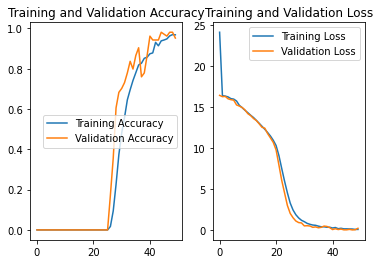

In [26]:
# Show acc and Loss curves for training and validation sets
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [27]:
model.save_weights(checkpoint_save_path)